# Unsupervised Learning Project: Iris Dataset

## Step 1: Data Collection and Provenance
The Iris dataset is sourced from the UCI Machine Learning Repository and is provided via `sklearn.datasets.load_iris`. This dataset contains 150 samples of iris flowers, with four features per sample. It is commonly used for clustering and classification tasks.

## Step 2: Unsupervised Learning Problem
**Problem Statement:** Cluster the iris flower samples based on their feature measurements without using the target labels to discover natural groupings. We will compare clustering algorithms and evaluate cluster quality using silhouette scores.

## Step 3: Exploratory Data Analysis (EDA)
- Inspect dataset structure
- Visualize feature distributions
- Analyze feature correlations
- Check for missing values and outliers

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

# Load data
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

# Display first few rows
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [2]:
# Dataset information and basic statistics
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


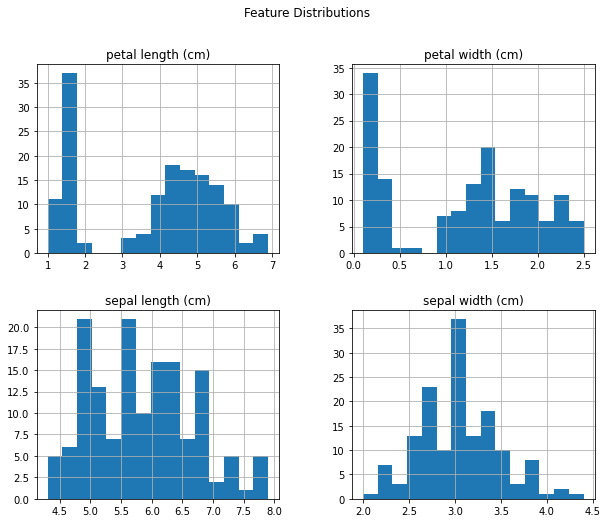

In [4]:
# Histograms for feature distributions
df[iris.feature_names].hist(bins=15, figsize=(10,8))
plt.suptitle("Feature Distributions")
plt.show()

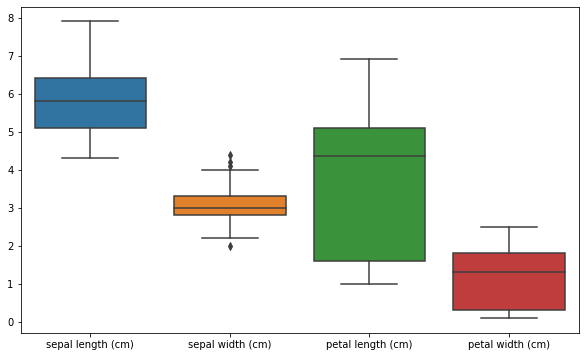

In [5]:
# Boxplots to detect outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=df[iris.feature_names])
plt.show()

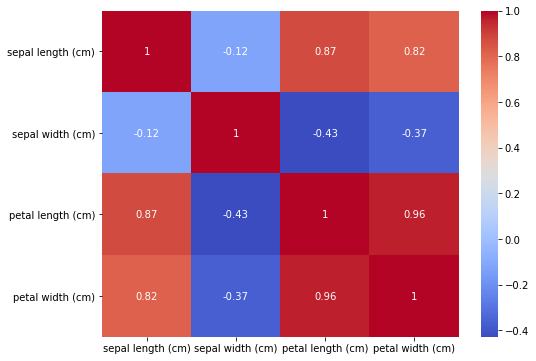

In [6]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[iris.feature_names].corr(), annot=True, cmap='coolwarm')
plt.show()

## Step 4: Data Cleaning and Transformation
- No missing values detected
- Features will be standardized for clustering algorithms sensitive to feature scale

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[iris.feature_names])

## Step 5: Model Building and Training
### K-Means Clustering
We will fit K-Means for k from 2 to 6 and evaluate using silhouette scores to choose optimal k.

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
K = range(2, 7)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"k={k}, silhouette score={score:.4f}")

k=2, silhouette score=0.5818
k=3, silhouette score=0.4599
k=4, silhouette score=0.4189
k=5, silhouette score=0.3459
k=6, silhouette score=0.3257


In [9]:
# Choose k with highest silhouette score
best_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"Best k by silhouette score: {best_k}")
# Fit final model
kmeans = KMeans(n_clusters=best_k, random_state=42)
df['kmeans_labels'] = kmeans.fit_predict(X_scaled)

Best k by silhouette score: 2


### Hierarchical Clustering
We apply Agglomerative Clustering with the same number of clusters as K-Means for comparison.

In [10]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=best_k)
df['agglo_labels'] = agglo.fit_predict(X_scaled)

### DBSCAN
We explore DBSCAN clustering to detect clusters of varying shape and noise.

In [11]:
from sklearn.cluster import DBSCAN

# Experiment with eps and min_samples
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_labels'] = dbscan.fit_predict(X_scaled)
print(df['dbscan_labels'].value_counts())

 1    71
 0    45
-1    34
Name: dbscan_labels, dtype: int64


## Clustering Plots

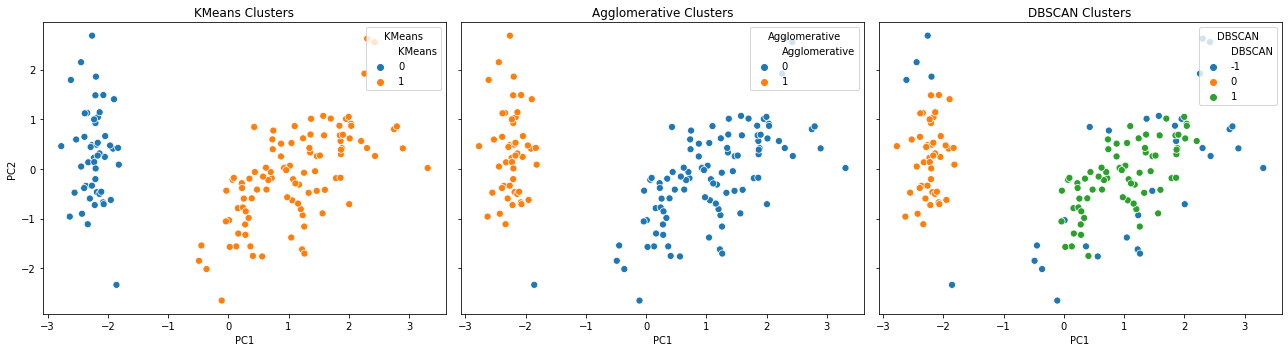

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 1) Project scaled data down to 2 principal components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 2) Build a small DataFrame for plotting
plot_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
plot_df['KMeans']       = df['kmeans_labels']
plot_df['Agglomerative']= df['agglo_labels']
plot_df['DBSCAN']       = df['dbscan_labels'].astype(str)  # make noise “-1” a separate category

# 3) Scatter‐plot for each clustering result
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

for ax, model in zip(axes, ['KMeans', 'Agglomerative', 'DBSCAN']):
    sns.scatterplot(
        x='PC1', y='PC2',
        hue=model,
        data=plot_df,
        palette='tab10',
        ax=ax,
        legend='full',
        s=50
    )
    ax.set_title(f"{model} Clusters")
    ax.legend(title=model, loc='upper right')

plt.tight_layout()
plt.show()

## Results and Discussion
- Silhouette scores suggest optimal number of clusters is `best_k=2`.
- K-Means and Agglomerative produce comparable clusters.
- DBSCAN labels `-1` as noise for some samples.
- Compare cluster assignments with true labels for qualitative analysis.

In [12]:
# Compare cluster labels with true species
pd.crosstab(df['target'], df['kmeans_labels'], rownames=['True'], colnames=['KMeans'])

KMeans,0,1
True,,
0,50,0
1,0,50
2,0,50


## Conclusion
- Unsupervised clustering can recover natural groupings similar to true species.
- K-Means and hierarchical clustering are effective for this dataset.
- DBSCAN may require parameter tuning to handle noise.
- Future work: explore Gaussian Mixture Models, perform dimensionality reduction before clustering.